In [1]:
import numpy as np
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils
from tf_agents.environments import py_environment
from threes_env import ThreesEnv

In [2]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"}
collect_steps_per_iteration = 10000 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 1024  # @param {type:"integer"}
learning_rate = 0.0005 # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [3]:
env = ThreesEnv()
train_py_env = ThreesEnv()
eval_py_env = ThreesEnv()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [4]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

def observation_and_action_constrain_splitter(observation):
    return observation['observation'], observation['actions']

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    observation_and_action_constraint_splitter=observation_and_action_constrain_splitter,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2021-10-23 01:20:53.238405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-23 01:20:53.262434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-23 01:20:53.262912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-23 01:20:53.263794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [6]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [7]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [7]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


In [13]:
compute_avg_return(eval_env, random_policy, 100)

NameError: name 'random_policy' is not defined

In [8]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmpqug6w540.
[reverb/cc/platform/tfrecord_checkpointer.cc:385] Loading latest checkpoint from /tmp/tmpqug6w540
[reverb/cc/platform/default/server.cc:71] Started replay server on port 23424


In [9]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

NameError: name 'random_policy' is not defined

In [9]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(
{action: (512, 2),
 discount: (512, 2),
 next_step_type: (512, 2),
 observation: {actions: (512, 2, 4),
                 observation: (512, 2, 17)},
 policy_info: (),
 reward: (512, 2),
 step_type: (512, 2)}), SampleInfo(key=(512, 2), probability=(512, 2), table_size=(512, 2), priority=(512, 2))), types: (Trajectory(
{action: tf.int32,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: DictWrapper({observation: tf.int32, actions: tf.int32}),
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), SampleInfo(key=tf.uint64, probability=tf.float64, table_size=tf.int64, priority=tf.float64))>

In [10]:
iterator = iter(dataset)
print(iterator)

2021-10-23 01:21:01.798062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

In [12]:
for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Distribution subclass MaskedCategorical inherits `_parameter_properties from its parent (Categorical)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['logits', 'probs']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3446) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3446) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3446) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3446) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3446) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3446) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Us

step = 100: loss = 165764944.0
step = 200: loss = 38470451200.0
step = 300: loss = 117489696768.0
step = 400: loss = 484127932416.0
step = 500: loss = 3542549004288.0
step = 600: loss = 12529392680960.0
step = 700: loss = 14292236632064.0
step = 800: loss = 13624241291264.0
step = 900: loss = 4261853265920.0
step = 1000: loss = 3349730820096.0
step = 1000: Average Return = 1464.0999755859375
step = 1100: loss = 3563423793152.0
step = 1200: loss = 2815974703104.0
step = 1300: loss = 1941859991552.0
step = 1400: loss = 1787122941952.0
step = 1500: loss = 1456563290112.0
step = 1600: loss = 883158286336.0
step = 1700: loss = 150469443584.0
step = 1800: loss = 676570923008.0
step = 1900: loss = 449598521344.0
step = 2000: loss = 559285207040.0
step = 2000: Average Return = 460.3999938964844
step = 2100: loss = 167426801664.0
step = 2200: loss = 234987913216.0
step = 2300: loss = 193161314304.0
step = 2400: loss = 175382511616.0
step = 2500: loss = 127877742592.0
step = 2600: loss = 2442226

In [13]:

import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iterations')

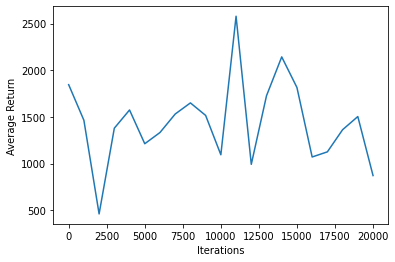

In [14]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [18]:
returns

[1394.8,
 1097.8,
 2943.4,
 1134.0,
 1099.0,
 2565.8,
 1537.1,
 3302.6,
 3063.9,
 962.3,
 2169.8,
 1310.1,
 792.0,
 1077.2,
 724.9,
 2386.5,
 1208.1,
 662.8,
 2448.5,
 1957.6,
 1383.8]